In [4]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas as pd
import pandas_ta as ta

from datetime import datetime, timedelta
from terminal.Extensions.MT5 import MT5

In [5]:
MT5.initialize()

In [6]:
slippage = 5

from_date = datetime(2024, 6, 5, tzinfo=pytz.utc)
to_date = datetime(2024, 6, 6, tzinfo=pytz.utc)

ticks = None

while from_date < to_date:
    range = mt5.copy_ticks_range("WDO$", from_date, from_date.replace(hour=23), mt5.COPY_TICKS_TRADE)
    if mt5.last_error()[0] == mt5.RES_S_OK:
        if ticks is None: 
            ticks = range
        else: 
            ticks = np.append(ticks, range, axis=0)
    from_date += timedelta(days=1)

In [7]:
all_trades = MT5.create_ticks_dataframe(ticks)
bulls_trades = all_trades[(all_trades["flags"] & mt5.TICK_FLAG_BUY == mt5.TICK_FLAG_BUY)]
bears_trades = all_trades[(all_trades["flags"] & mt5.TICK_FLAG_SELL == mt5.TICK_FLAG_SELL)]

<Axes: xlabel='time_msc'>

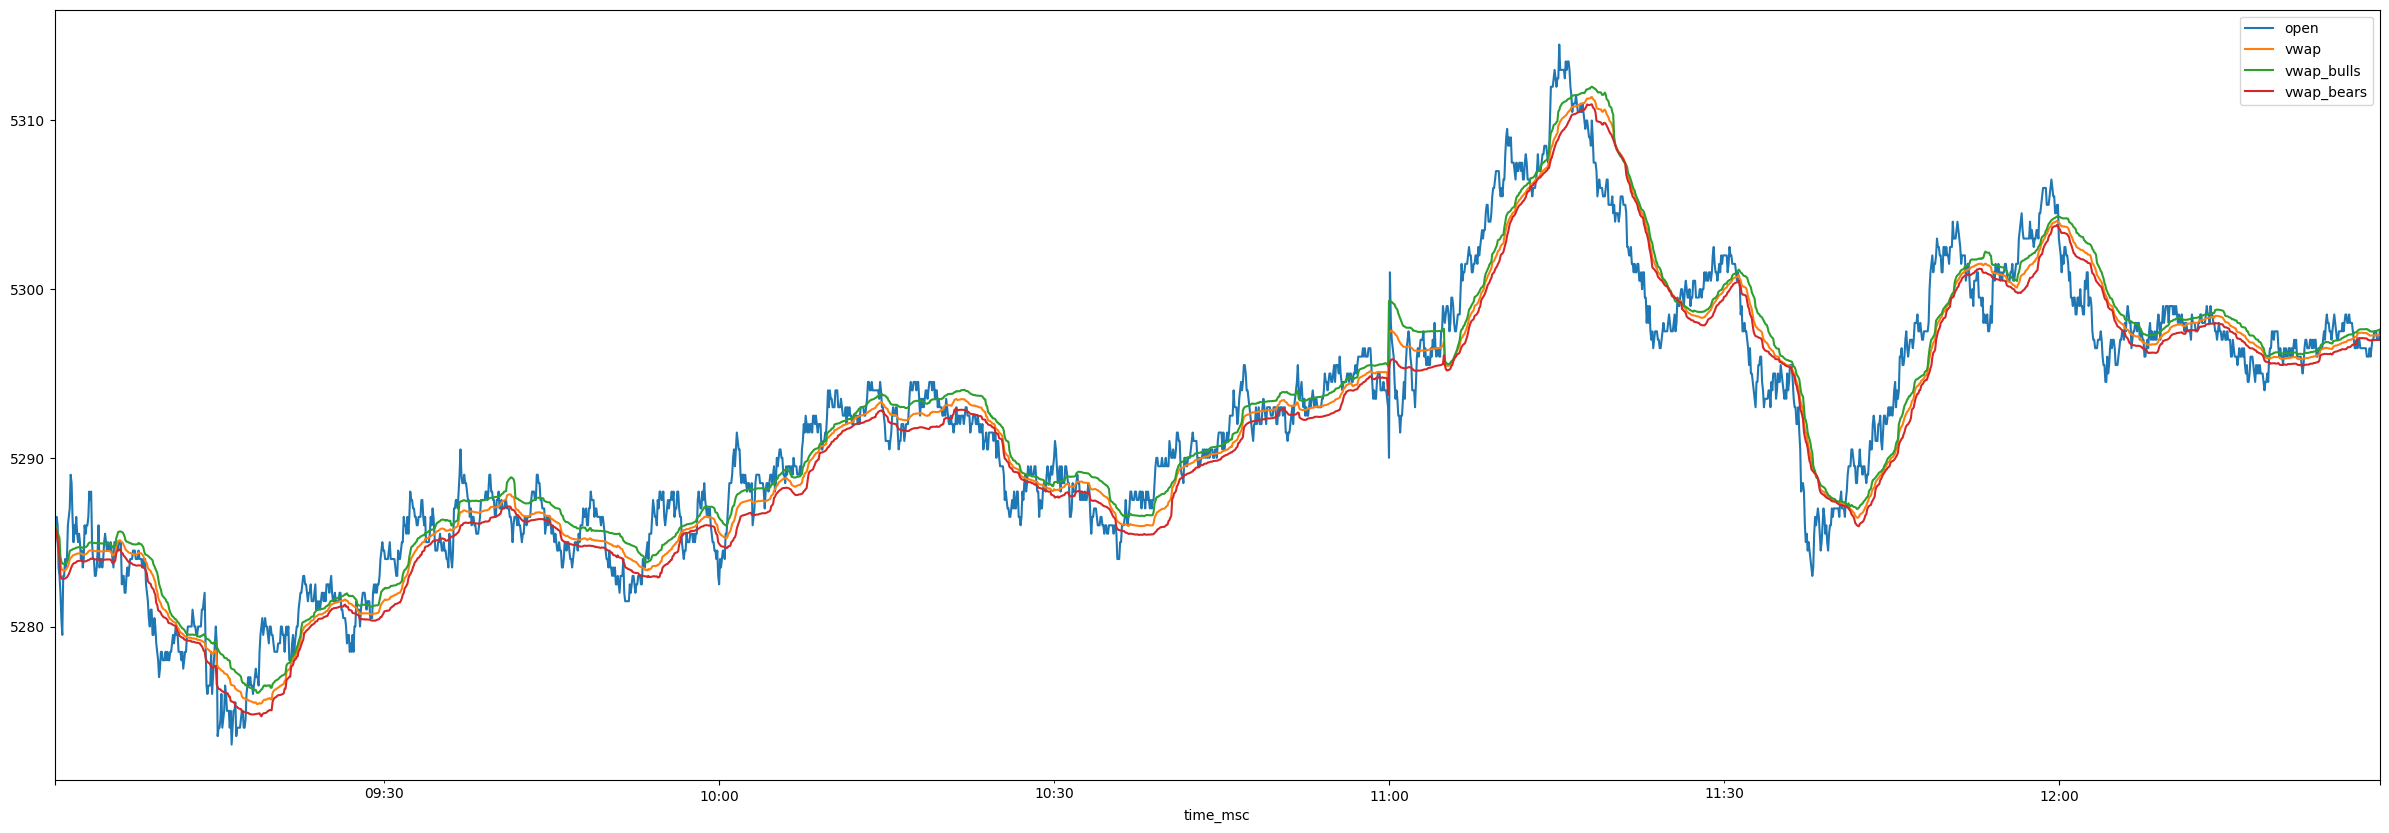

In [13]:
timeframe = "5s"

ratesjoin = MT5.create_ohlc_from_ticks(all_trades, timeframe)
bulls_rates = MT5.create_ohlc_from_ticks(bulls_trades, timeframe)
bears_rates = MT5.create_ohlc_from_ticks(bears_trades, timeframe)

ratesjoin = ratesjoin.join(bulls_rates, rsuffix="_bulls").join(bears_rates, rsuffix="_bears")

vwap_window = "5min"

ratesjoin["vwap"] = (ratesjoin["close"] * ratesjoin["real_volume"]).rolling(vwap_window).sum() / ratesjoin["real_volume"].rolling(vwap_window).sum()
ratesjoin["vwap_bulls"] = (ratesjoin["close_bulls"] * ratesjoin["real_volume_bulls"]).rolling(vwap_window).sum() / ratesjoin["real_volume_bulls"].rolling(vwap_window).sum()
ratesjoin["vwap_bears"] = (ratesjoin["close_bears"] * ratesjoin["real_volume_bears"]).rolling(vwap_window).sum() / ratesjoin["real_volume_bears"].rolling(vwap_window).sum()

ratesjoin.to_excel("ratesjoin.xlsx")

ratesjoin.iloc[:2500][["open", "vwap", "vwap_bulls", "vwap_bears"]].plot(figsize=(30, 10))

In [77]:
ratesjoin["entry"] = 0
ratesjoin["exit"] = 0

ratesjoin.loc[(ratesjoin["open"] > ratesjoin.shift(1)["open"]) & (ratesjoin.shift(1)["open"] > ratesjoin.shift(2)["open"]), "entry"] = 1

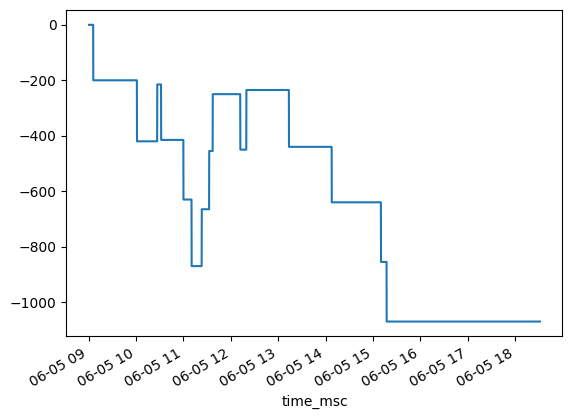

In [80]:
ratesjoin["buy_price"] = np.nan
ratesjoin["sell_price"] = np.nan
ratesjoin["position_profit"] = 0
ratesjoin["close_profit"] = 0
ratesjoin["profit"] = 0

position = 0
position_profit = 0

take_profit = 200
stop_loss = -200

for i, item in ratesjoin.iterrows():
    if position == 0:
        if item.entry == 1:
            ratesjoin.loc[i, "buy_price"] = buy_price = item.open + slippage
            position = 1
        elif item.entry == -1:
            ratesjoin.loc[i, "sell_price"] = sell_price = item.open - slippage
            position = -1
    elif position == 1:
        sell_price = item.open - slippage
        position_profit = sell_price - buy_price
        ratesjoin.loc[i, "position_profit"] = position_profit
        if item.exit or item.entry == -1 or position_profit >= take_profit or position_profit <= stop_loss:
            ratesjoin.loc[i, "sell_price"] = sell_price
            ratesjoin.loc[i, "close_profit"] = position_profit
            position = 0      
    elif position == -1:
        buy_price = item.open + slippage
        position_profit = sell_price - buy_price
        ratesjoin.loc[i, "position_profit"] = position_profit
        if item.exit or item.entry == 1 or position_profit >= take_profit or position_profit <= stop_loss:
            ratesjoin.loc[i, "buy_price"] = buy_price = item.open + slippage
            ratesjoin.loc[i, "close_profit"] = sell_price - buy_price
            position = 0
            

ratesjoin["profit"] = ratesjoin["close_profit"].cumsum()
ratesjoin["profit"].plot()

ratesjoin.to_excel("output_result.xlsx")